# 2019 Computer Vision (AAA534)

## Week 1. linear filter

Code by JunYeup Cho, JongMin Lee

In [1]:
# import opencv, numpy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Part 0) Using OpenCV with Python

In [2]:
# import image with cv2.imread(name, flag)
TestImgColor     = cv2.imread("test.jpg", cv2.IMREAD_COLOR)     # == cv2.imread("test.jpg", 1)
TestImgGray      = cv2.imread("test.jpg", cv2.IMREAD_GRAYSCALE) # == cv2.imread("test.jpg", 0)
## unchanged images also loads alpha channel
TestImgUnchanged = cv2.imread("test.jpg", cv2.IMREAD_UNCHANGED) # == cv2.imread("test.jpg", -1)

In [3]:
# display image with cv2.imshow(window name, img)
# this function needs gtk+ 2.x library, otherwise use matplotlib.
cv2.imshow('color image', TestImgColor)
cv2.imshow('gray image', TestImgGray)
cv2.imshow('unchanged image', TestImgUnchanged)
# wait untill pressing any key
cv2.waitKey(0)
cv2.destroyAllWindows()

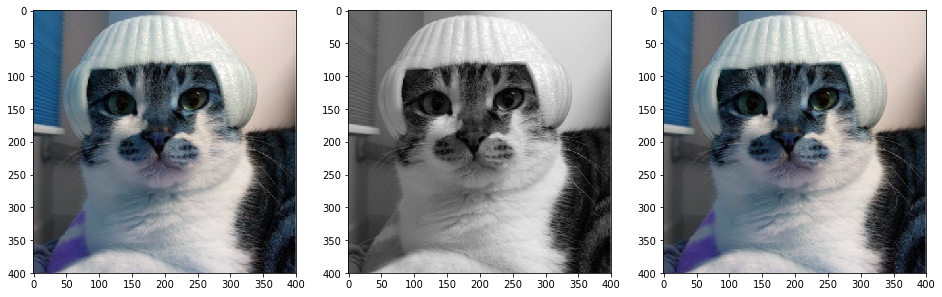

In [4]:
# display image with plt.imshow(img)
fig = plt.figure(figsize = (16, 16))
fig.add_subplot(1, 3, 1) # (row, column, index)
plt.imshow(TestImgColor)
fig.add_subplot(1, 3, 2)
plt.imshow(TestImgGray, cmap = 'gray')
fig.add_subplot(1, 3, 3)
plt.imshow(TestImgUnchanged)
plt.show()

In [5]:
# utility function for displaying multiple images
def ShowImgs(images, titles, row, column, size):
    fig = plt.figure(figsize = size)
    for i in range(len(images)):
        # cmap = 'gray' is ignored if image is 3D
        fig.add_subplot(row, column, i+1), plt.imshow(images[i], cmap = 'gray'), plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()

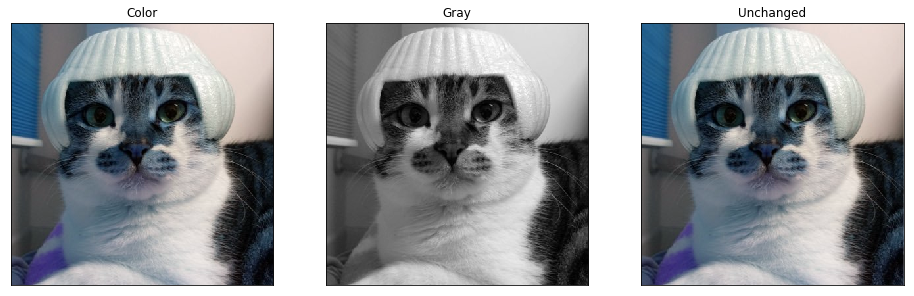

In [6]:
images = [TestImgColor, TestImgGray, TestImgUnchanged]
titles=['Color', 'Gray', 'Unchanged']
ShowImgs(images, titles, 1, 3, (16, 16))

### Part 1) Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


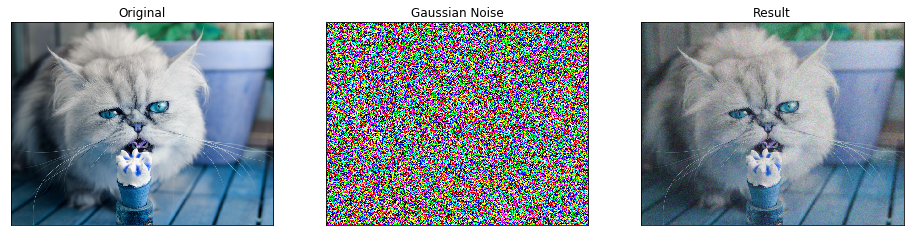

In [7]:
# Add Gaussian noise to an image
img = cv2.imread('noise.jpg')

mean = 0
var = 100
sigma = var ** 0.5

gaussian = np.random.normal(mean, sigma, img.shape)

noisy_image = np.zeros(img.shape, np.float32)
noisy_image = img + gaussian

cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
noisy_image = noisy_image.astype(np.uint8)

images = [img, gaussian, noisy_image]
titles=['Original', 'Gaussian Noise', 'Result']
ShowImgs(images, titles, 1, 3, (16, 16))

### Part 2) Noise Reduction

In [8]:
# Averaging with cv2.blur(src, ksize)
img = cv2.imread('blur.jpg')

avg = cv2.blur(img,(7,7))

In [9]:
# Gaussian filtering with cv2.GaussianBlur(img, ksize, sigmaX)
gauss = cv2.GaussianBlur(img,(5,5),10)

In [10]:
# median filtering cv2.medianBlur(src, ksize)
median = cv2.medianBlur(img, 5)

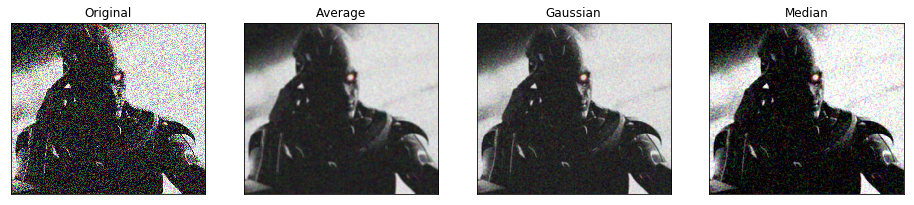

In [11]:
images = [img, avg, gauss, median]
titles=['Original', 'Average', 'Gaussian', 'Median']
ShowImgs(images, titles, 1, 4, (16, 16))

### Part 3) Linear Filter

In [12]:
# sharping filtering with cv2.addWeighted()
img = cv2.imread('filter.jpg', cv2.IMREAD_GRAYSCALE)

blurred = cv2.GaussianBlur(img,(0,0), 1)
filtered_img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0.0)

In [13]:
# cv2.filter2D() convolve a kernel with an image 
kernel = np.zeros((3,3),np.float32)
kernel[1][1] = 5
kernel[1][0] = -1                  #  0 -1  0 
kernel[0][1] = -1                  # -1  5 -1
kernel[1][2] = -1                  #  0 -1  0
kernel[2][1] = -1
filtered = cv2.filter2D(img, -1, kernel)

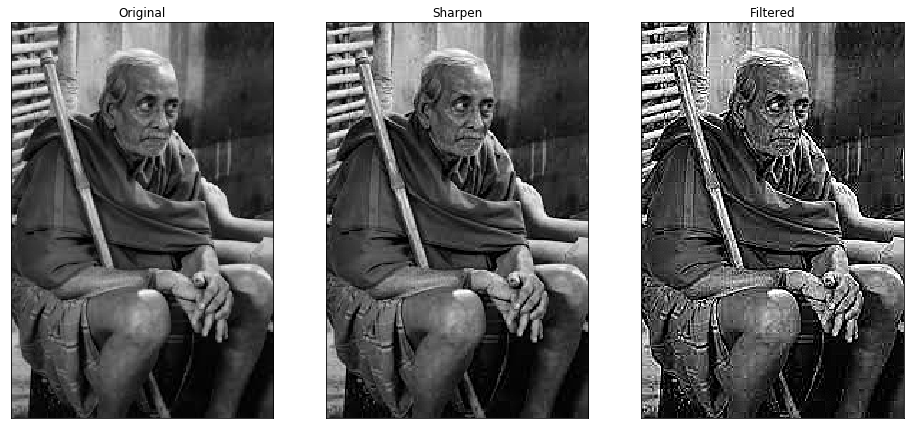

In [14]:
images = [img, filtered_img, filtered]
titles=['Original', 'Sharpen', 'Filtered']
ShowImgs(images, titles, 1, 3, (16, 16))

In [15]:
## original code from : https://github.com/j2kun/hybrid-images
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import misc
from scipy import ndimage
import math

def scaleSpectrum(A):
    return np.real(np.log10(numpy.absolute(A) + np.ones(A.shape)))

# sample values from a spherical gaussian function from the center of the image
def makeGaussianFilter(numRows, numCols, sigma, highPass=True):
    centerI = int(numRows/2) + 1 if numRows % 2 == 1 else int(numRows/2)
    centerJ = int(numCols/2) + 1 if numCols % 2 == 1 else int(numCols/2)

    def gaussian(i,j):
        coefficient = math.exp(-1.0 * ((i - centerI)**2 + (j - centerJ)**2) / (2 * sigma**2))
        return 1 - coefficient if highPass else coefficient

    return np.array([[gaussian(i,j) for j in range(numCols)] for i in range(numRows)])

def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = fftshift(fft2(imageMatrix))
    #misc.imsave("dft.png", scaleSpectrum(shiftedDFT))

    filteredDFT = shiftedDFT * filterMatrix
    #misc.imsave("filtered-dft.png", scaleSpectrum(filteredDFT))
    return ifft2(ifftshift(filteredDFT))

def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=False))

def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=True))

def hybridImage(highFreqImg, lowFreqImg, sigmaHigh, sigmaLow):
    highPassed = highPass(highFreqImg, sigmaHigh)
    lowPassed = lowPass(lowFreqImg, sigmaLow)

    return highPassed + lowPassed

In [16]:
# generate hybrid image
einstein = ndimage.imread("einstein.png", flatten=True)
marilyn = ndimage.imread("marilyn.png", flatten=True)

hybrid = hybridImage(einstein, marilyn, 25, 10)
# save hybrid image
misc.imsave("marilyn-einstein.png", np.real(hybrid))

/home/medialab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/medialab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/medialab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys
